# Using `enterprise_extensions` to search for a stochastic gravitational wave background with a single pulsar

In this notebook you will learn:
* How to use `enterprise_extensions` to interact with NANOGrav data,
* How to do parameter estimation with `enterprise` and `enterprise_extensions`,
* How to compute Bayes factors using the Savage-Dickey approximation.

# Load packages and modules

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

# enterprise_extensions imports:
import enterprise_extensions
from enterprise_extensions import models, model_utils, hypermodel

import sys
sys.path.append("..")
from settings import fd_bins

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get par, tim, and noise files
* In this tutorial we will use J1713
* Samples from the posterior have been included for this pulsar,
* but you may change this to any pulsar in the 12.5 year data set and do the sampling yourself

In [19]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = '../data'
if not os.path.isdir(datadir):
    datadir = '../../data'
print(datadir)

../../data


In [20]:
# Get J1713 only
psrname = 'J1713'
parfiles = sorted(glob.glob(datadir + '/par/' + psrname + '*par'))
timfiles = sorted(glob.glob(datadir + '/tim/' + psrname + '*tim'))

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile...
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]
print(parfiles)
print(timfiles)

['../../data/par/J1713+0747_NANOGrav_12yv3.gls.t2.par']
['../../data/tim/J1713+0747_NANOGrav_12yv3.tim']


### Load pulsars

In [21]:
psrs = []
ephemeris = 'DE438'
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


### Get noise dictionary

In [22]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

### Create model with common red process

* This sets up the pta model (everything we did in the verbose version) all in one cell
* This model 2a includes:
  * fixed white noise parameters based on noisedict
  * common red noise signal (no correlation function) with 5 sampling frequencies (default 30 frequencies)
  * common red noise spectral index = 13/3 - this corresponds to an ensemble of supermassive black hole mergers making up the background
  * the number of frequencies to be used has been changed from 30 to 5 to match the search performed in the 12.5 year SGWB search paper

In [23]:
pta = models.model_2a(psrs,
                      psd='powerlaw',
                      noisedict=params,
                      n_gwbfreqs=5,  # modify the number of common red noise frequencies here
                      gamma_common=13/3)  # remove this line for a varying spectral index

## Setup an instance of a `HyperModel`
* This doesn't mean we are doing model selection (yet!), but the 
* `HyperModel` gives access to some nifty sampling schemes.

In [24]:
super_model = hypermodel.HyperModel({0: pta})

### Sample with PTMCMCSampler
* Chains have been included to save time sampling

In [25]:
outDir = '../../chains/sngl_gwb_ext'
sampler = super_model.setup_sampler(resume=False, outdir=outDir, sample_nmodel=True)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...



/Users/aaron/opt/anaconda3/envs/enterprise/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


### Sampler for N steps
* Samples have been included for you, but if you would like to sample it yourself, uncomment the last line in this cell

In [26]:
N = int(5e6)
x0 = super_model.initial_sample()
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [27]:
# Uncomment this one to load the chain if you have sampled with PTMCMCSampler:
# chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))

# This will load the samples that we have provided:
chain = np.load(os.path.join(outDir, 'chain_1.npz'))['arr_0']
burn = int(0.25 * chain.shape[0])  # remove burn in segment of sampling

In [28]:
ind = list(pta.param_names).index('gw_log10_A')

### Make trace-plot to diagnose sampling
* Trace plots should look like a fuzzy caterpillar and not like a skinny worm!

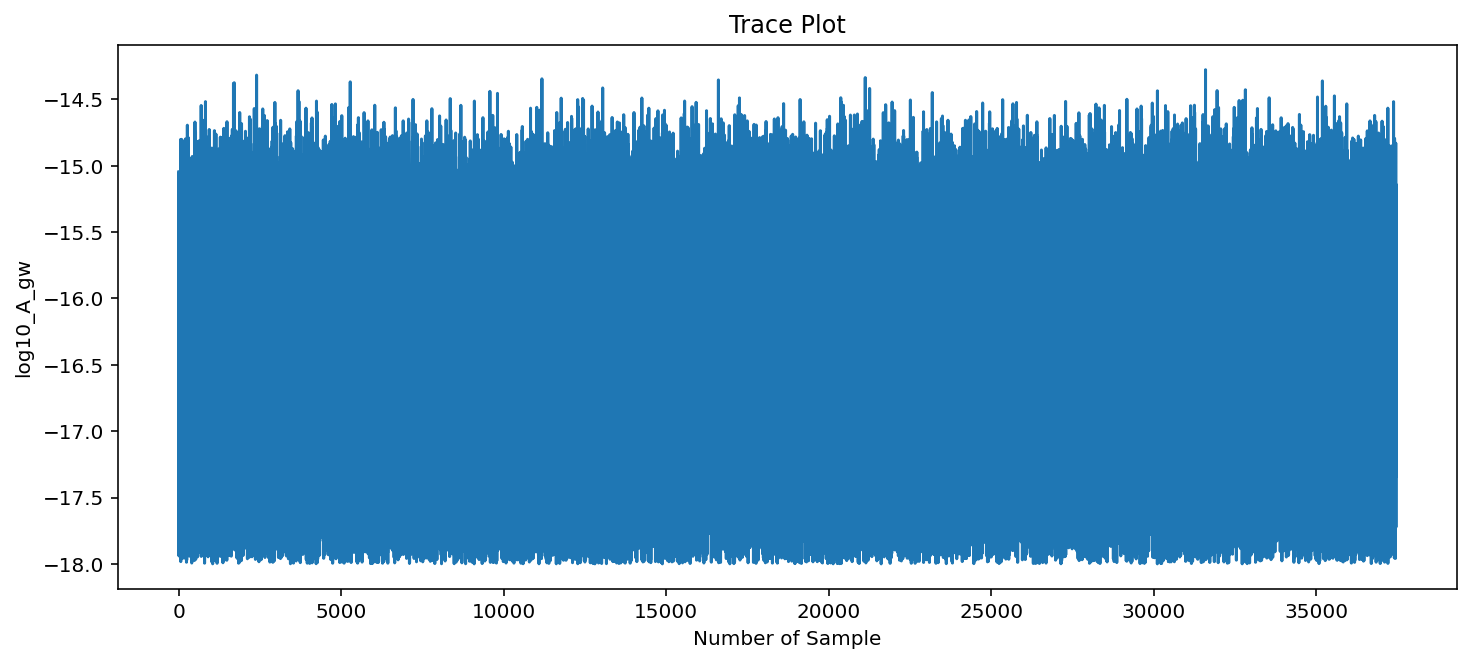

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(chain[burn:, ind])
plt.xlabel('Number of Sample')
plt.ylabel('log10_A_gw')
plt.title('Trace Plot')
plt.show()

### Plot a histogram of the marginalized posterior distribution

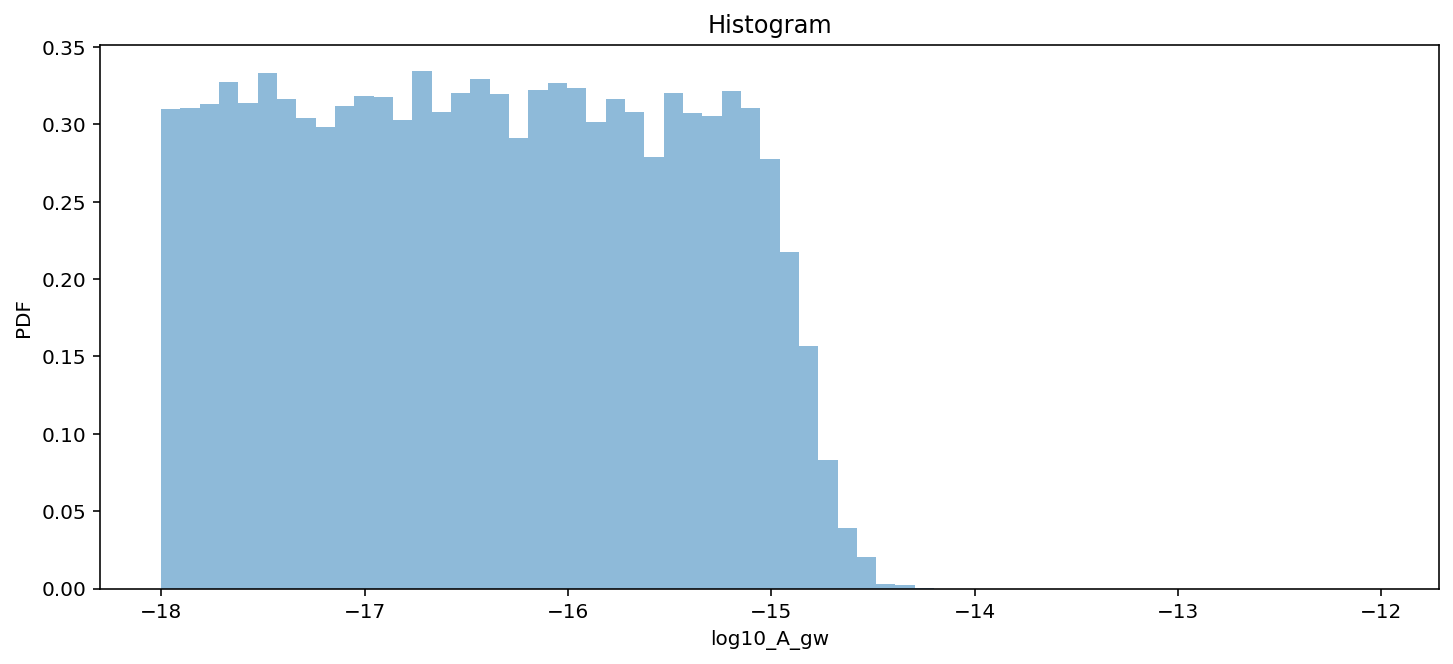

In [32]:
bins = fd_bins(chain[burn:, ind], logAmin=-18, logAmax=-12)  # let FD rule decide bins (in ../settings.py)
plt.figure(figsize=(12, 5))
plt.title('Histogram')
plt.hist(chain[burn:,ind], bins=bins, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5, density=True)
plt.xlabel('log10_A_gw')
plt.ylabel('PDF')
plt.show()

## Savage Dickey Approximation Bayes factor
* As long as the posterior has a tail that extends to the lower limit of the prior with enough samples, we can compare that tail with the prior to compute a quick Bayes factor between two models differing in one parameter by taking the limit as that parameter goes to zero.
* To do this, we take a function from `enterprise_extensions` which will divide the prior by the posterior in the limit as $\log_{10}A_{gw} \rightarrow 0$.
* For more information, see Section 6.3.5 in [The Nanohertz Gravitational Wave Astronomer](https://arxiv.org/pdf/2105.13270.pdf) by Steve R. Taylor

In [33]:
from enterprise_extensions.model_utils import bayes_fac

In [34]:
bf = bayes_fac(chain[burn:,ind], ntol=0, logAmin=-18, logAmax=-12)
print(bf)

(0.5221296546523881, 0.01296824450558217)


In [35]:
log10_bf = np.log10(bf[0])
print(log10_bf)

-0.28222164008528683


## Remarks
* J1713 doesn't currently support a common red process in the data
* Investigations into this are ongoing